Project for compressing images and reconstructing images where known pixels have been lost.

In [1]:
%pip install numpy pandas matplotlib scipy

  Using cached numpy-2.4.0-cp314-cp314-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.8-cp314-cp314-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached scipy-1.16.3-cp314-cp314-macosx_14_0_arm64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 4.5 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 4.2 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 4.2 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 5.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [matplotlib]2 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import time

Matplotlib is building the font cache; this may take a moment.


# Goal 1: Householder Scheme for QR factorization

In [3]:
def householder_QR (B):
  """
  Computes the QR factorization of a n * k matrix B with k <= n.
  Returns householder_vectors, a n * k to  matrix to represent Q where column i
  contains the corresponding housoholder vector, and R an upper triangular
  matrix.
  """
  n, k = B.shape
  householder_vectors = np.zeros_like(B, dtype=float)
  R = B.copy().astype(float)
  for i in range (k):
    x = R[i:n, i]
    vi = x.copy()
    sign = np.sign(x[0]) if x[0] != 0 else 1
    vi[0] += sign * np.linalg.norm(x)
    vi = vi / np.linalg.norm(vi)
    R[i:n, i:k] -= 2 * np.outer(vi, np.dot(vi, R[i:n, i:k]))
    householder_vectors[i:n, i] = vi
  return householder_vectors, R[:k,:]

In [4]:
def form_Q(householder_vectors):
    """
    Reconstructs the full orthogonal matrix Q from the Householder vectors.
    """
    n, k = householder_vectors.shape
    Q = np.eye(n)
    for i in range(k-1, -1, -1):
        vi = householder_vectors[i:n, i]
        H = np.eye(n-i) - 2 * np.outer(vi, vi)
        Q[i:n, :] = H @ Q[i:n, :]
    return Q

In [5]:
def verify_QR(B):
    """
    Computes the QR factorization of a matrix B and verifies the results.

    Checks the norm of the difference between B and QR.

    CHecks the norm of the difference between Q^T * Q and the identity matrix.

    Checks that R is upper triangular.
    """
    H_vec, R = householder_QR(B)
    Q_full = form_Q(H_vec)
    k = R.shape[0]
    Q = Q_full[:, :k] # Only take the first k columns to have the square matrix (see https://en.wikipedia.org/wiki/QR_decomposition#Rectangular_matrix)

    reconstruction_error = np.linalg.norm(B - Q @ R, ord='fro')
    orthogonality_error = np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), ord='fro')
    if np.allclose(R, np.triu(R)):
      print("R is upper triangular")
    else:
      print("R is not upper triangular")

    return reconstruction_error, orthogonality_error

In [6]:
sizes = [50, 100, 200, 400, 800]
num_trials = 5

avg_reconstruction_errors = []
avg_orthogonality_errors = []
avg_runtimes = []

for n in sizes:
    k = n // 2
    rec_errors = []
    ortho_errors = []
    runtimes = []

    for trial in range(num_trials):
        np.random.seed(trial)
        B = np.random.uniform(low=-50, high=50, size=(n, k))

        start_time = time.time()
        rec_err, ortho_err = verify_QR(B)
        end_time = time.time()

        rec_errors.append(rec_err)
        ortho_errors.append(ortho_err)
        runtimes.append(end_time - start_time)

    avg_reconstruction_errors.append(np.mean(rec_errors))
    avg_orthogonality_errors.append(np.mean(ortho_errors))
    avg_runtimes.append(np.mean(runtimes))

R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular
R is upper triangular


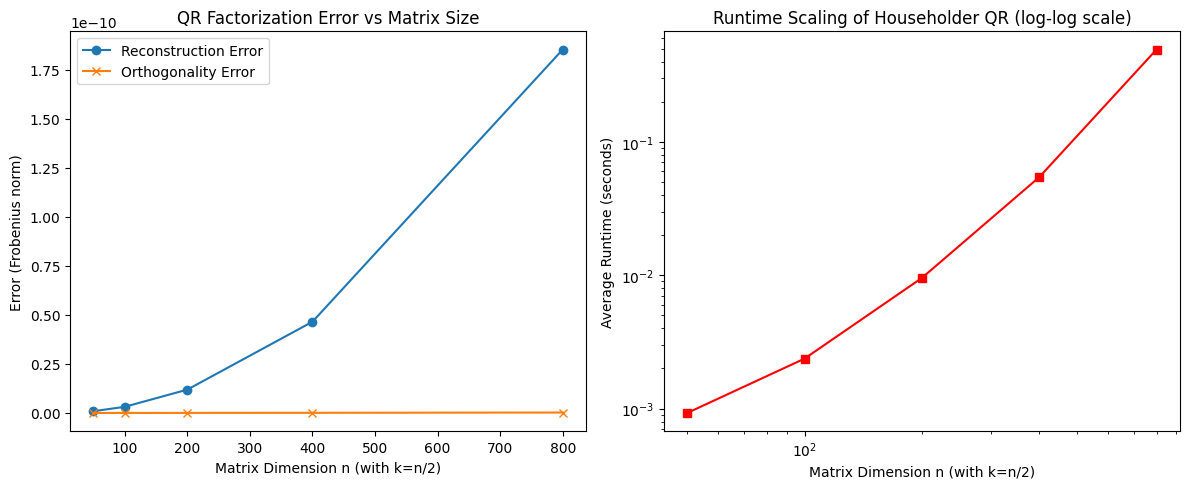

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sizes, avg_reconstruction_errors, marker='o', label='Reconstruction Error')
plt.plot(sizes, avg_orthogonality_errors, marker='x', label='Orthogonality Error')
plt.xlabel("Matrix Dimension n (with k=n/2)")
plt.ylabel("Error (Frobenius norm)")
plt.title("QR Factorization Error vs Matrix Size")
plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(sizes, avg_runtimes, marker='s', color='r')  # Using log-log scale
plt.xlabel("Matrix Dimension n (with k=n/2)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime Scaling of Householder QR (log-log scale)")

plt.tight_layout()
plt.show()

# Goal 2: Implementing alternate least squares, without regularization

In [25]:
def backward_substitution(R, y):
    """
    Solves the upper triangular system R x = y using backward substitution.
    """
    k = R.shape[0]
    x = np.zeros_like(y)
    for i in range(k-1, -1, -1):
        x[i] = (y[i] - np.dot(R[i, i+1:], x[i+1:])) / R[i, i]
    return x

In [26]:
def update(A, W):
    """
    Solves for Z or W in the problem
        min_{X} ||a - W X||_F^2
    by updating the missing factor using QR factorization and backward substitution
    on each vector least squares subproblem.

    When updating Z:
      - A is the original matrix (n1 x n2) and W (n1 x k) is fixed.
      - The j-th column of A gives the least squares problem for z (in R^k),
        and the solution z is stored as the j-th row of Z.

    When updating W:
      - A should be transposed and the same function is used, exploiting the symmetry.
    """
    n1, n2 = A.shape
    k = W.shape[1]
    H_w, R_w = householder_QR(W)
    Q_w_full = form_Q(H_w)
    Q_w = Q_w_full[:, :k]

    X = np.zeros((n2, k))
    for j in range(n2):
        a_j = A[:, j]        # j-th column of A
        y = Q_w.T @ a_j
        x = backward_substitution(R_w, y)
        X[j, :] = x          # each row of X corresponds to the solution for that subproblem
    return X

In [27]:
def als_until_convergence(A, k, tol=1e-6, max_iters=10, window=5):
    """
    Alternating Least Squares (ALS) algorithm with convergence check using a window of
    recent errors.

    Parameters:
      A       : An n1 x n2 matrix.
      k       : Target rank.
      tol     : Tolerance for convergence (average change over the last window).
      max_iters: Maximum number of iterations.
      window  : Number of recent iterations to consider for convergence.

    Returns:
      W, Z    : Matrices such that A ≈ W Z^T.
    """
    n1, n2 = A.shape
    # Initialize W (n1 x k) and Z (n2 x k) with random values.
    W = np.random.rand(n1, k)
    Z = np.random.rand(n2, k)

    error_buffer = []
    iter_count = 0

    while iter_count < max_iters:
        print(f'Starting iteration {iter_count}')
        Z = update(A, W)
        W = update(A.T, Z)

        error = np.linalg.norm(A - W @ Z.T, ord='fro')
        # print(f"Iteration {iter_count+1}, reconstruction error = {error:.4e}")

        error_buffer.append(error)
        if len(error_buffer) > window:
            error_buffer.pop(0)

        if len(error_buffer) == window:
            # Compute the differences between consecutive errors
            diffs = np.abs(np.diff(error_buffer))
            avg_diff = np.mean(diffs)
            if avg_diff < tol:
                # print("Convergence achieved based on average change over window!")
                break

        iter_count += 1
    # print(W)
    # print(Z)
    return W, Z

In [28]:
# Example use:
np.random.seed(4)
A = np.random.rand(20, 15)
k = 15
W, Z = als_until_convergence(A, k, tol=1e-6, max_iters=100, window=5)
print("Final reconstruction error:", np.linalg.norm(A - W @ Z.T, ord='fro'))

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Final reconstruction error: 1.241642236541772e-14


# Goal 3: Best rank 75 approximation of the image

In [12]:
from pathlib import Path

data_path = Path("data") / "Cornell.csv"
cornell = np.genfromtxt(data_path, delimiter=',')
print(cornell)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


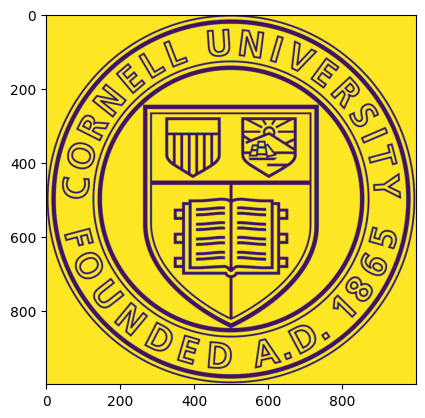

In [13]:
plt.imshow(cornell)
plt.show()

In [14]:
rank = 75
W_cornell, Z_cornell = als_until_convergence(cornell, rank, tol=1e-6, max_iters=30, window=5)
print("Final reconstruction error:", np.linalg.norm(cornell - W_cornell @ Z_cornell.T, ord='fro'))

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Starting iteration 11
Starting iteration 12
Starting iteration 13
Starting iteration 14
Starting iteration 15
Starting iteration 16
Starting iteration 17
Starting iteration 18
Starting iteration 19
Starting iteration 20
Starting iteration 21
Starting iteration 22
Starting iteration 23
Starting iteration 24
Starting iteration 25
Starting iteration 26
Starting iteration 27
Starting iteration 28
Starting iteration 29
Final reconstruction error: 83.87882576619562


In [15]:
U_k, S_k, V_T_k = svds(cornell, k=rank) # using scipy built in function to get biggest k
S_k = np.diag(S_k) # to diag

print("Final reconstruction error:", np.linalg.norm(cornell - (U_k @ S_k @ V_T_k), ord='fro'))

Final reconstruction error: 83.86689961572921


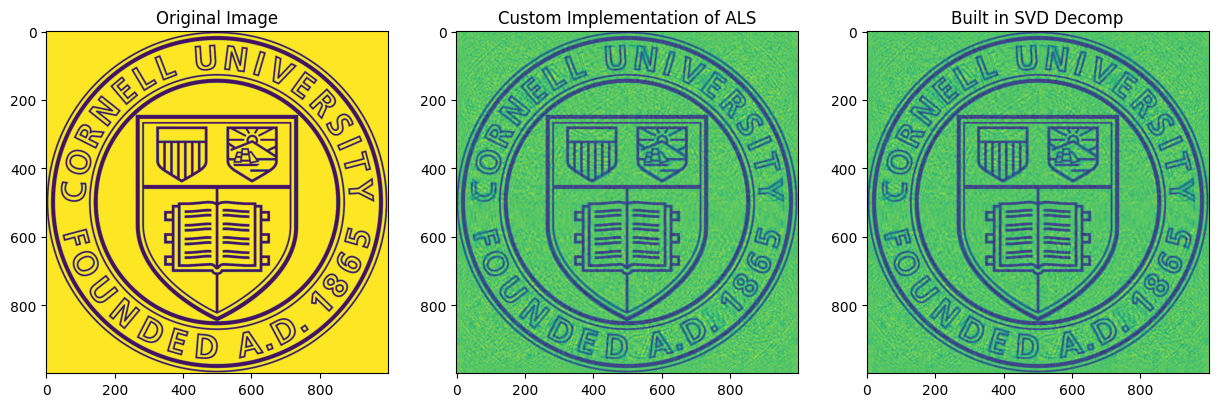

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(cornell)
axes[0].set_title("Original Image")

als_until_convergence_cornell = W_cornell @ Z_cornell.T
axes[1].imshow(als_until_convergence_cornell)
axes[1].set_title("Custom Implementation of ALS")

built_in_cornell = U_k @ S_k @ V_T_k # reconstructed image
axes[2].imshow(built_in_cornell)
axes[2].set_title("Built in SVD Decomp")

plt.savefig("method_comp_fig.png", dpi=300, bbox_inches='tight')
plt.show()

# Goal 4: Implementing lternating least squares, with regularization and unknown entries

In [17]:
def update_masked (A, M, WZ, beta):
  """
  Computes the updated W or Z using only available pixel values

  Parameters:
      A       : An n1 x n2 matrix.
      M       : The pixel mask which determines which pixels are available
      WZ      : W or Z whichever is inputted
      beta    : Regularization parameter

    Returns:
      Z       : Either W or Z, depending on which on is inputted


  """
  n1, n2 = A.shape
  k = WZ.shape[1]
  Z = np.zeros((n2, k))

  for j in range(n2):
    rows = np.where(M[:, j] == 1)[0]

    if rows.size == 0: # skip if empty column
      continue

    W_j = WZ[rows, :] # existing pixels
    b_j = A[rows, j]

    A_aug = np.vstack((W_j, beta * np.eye(k))) # [Wj \\ BI]
    b_aug = np.hstack((b_j, np.zeros(k))) # [b \\ 0]

    Q, R = householder_QR(A_aug)
    Q_full = form_Q(Q)
    Q_reduced = Q_full[:, :k]
    y = Q_reduced.T @ b_aug
    z_j = backward_substitution(R[:k, :], y[:k])
    Z[j, :] = z_j

  return Z


In [18]:
def als_reg_unkown_entries (A, M, k, beta=0.1, max_iters=75):
  """
  Computes the Alternating least squares, with regularization and unknown entries algorithm.

  A is the matrix representing what we know from the image

  M is the mask with entry 1 if the pixel is known

  beta is the regularization parameter

  max_iters is the maximum number of iterations
  """
  n1, n2 = A.shape
  W = np.random.rand(n1, k)
  Z = np.random.rand(n2, k)

  iter_count = 0
  error_buffer = []

  while iter_count < max_iters:
      print(f'Starting iteration {iter_count}')
      Z = update_masked(A, M, W, beta)
      W = update_masked(A.T, M.T, Z, beta)

      iter_count += 1

  return W, Z



# Goal 5: Trying to recover images whose data has been lost according to the mask

In [19]:
DATA_DIR = Path("data")

imgs = []
for i in range(1, 4):
    imgs.append({
        "img":  np.genfromtxt(DATA_DIR / f"Image{i}.csv", delimiter=","),
        "mask": np.genfromtxt(DATA_DIR / f"Mask{i}.csv",  delimiter=","),
    })

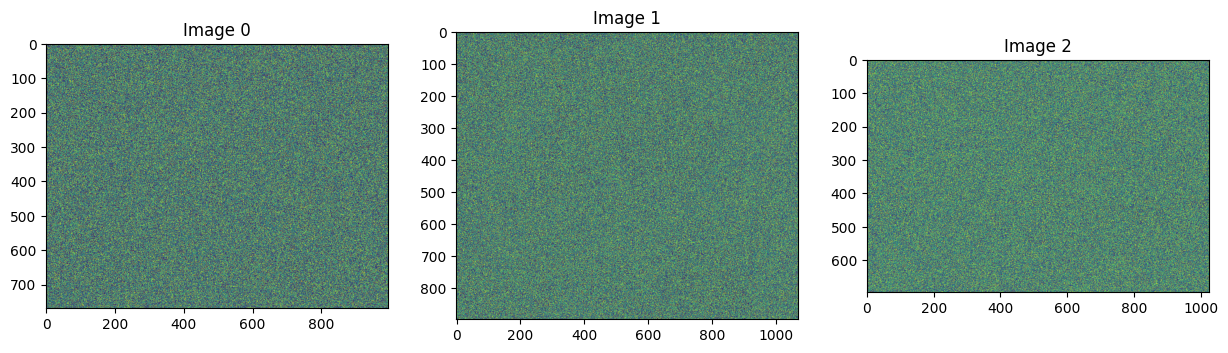

In [20]:
fig, axes = plt.subplots(1, len(imgs), figsize=(5*len(imgs),5))

for i in range(len(imgs)):
  axes[i].imshow(imgs[i]["img"])
  axes[i].set_title(f"Image {i}")

plt.show()

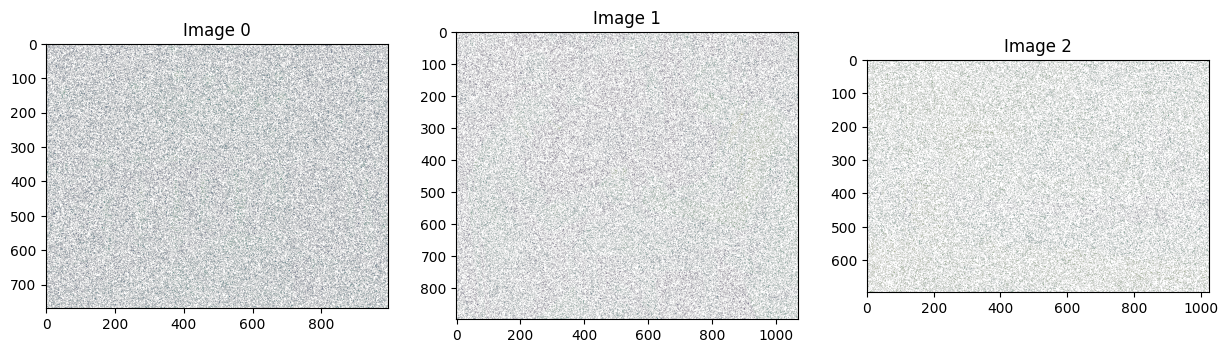

In [21]:
fig, axes = plt.subplots(1, len(imgs), figsize=(5*len(imgs),5))

for i in range(len(imgs)):
  axes[i].imshow(np.ma.masked_where(imgs[i]["mask"] == 0, imgs[i]["img"]))
  axes[i].set_title(f"Image {i}")

plt.show()

In [22]:
k=75

reconstruction = []

for img in imgs:
  print("\nStarting next iteration")
  W_5, Z_5 = als_reg_unkown_entries(img["img"], img["mask"], k, beta=0.5,max_iters=10)
  W_1, Z_1 = als_reg_unkown_entries(img["img"], img["mask"], k, beta=1,max_iters=10)

  reconstruction.append({
      "W_5": W_5,
      "Z_5": Z_5,
      "W_1": W_1,
      "Z_1": Z_1
  })



Starting next iteration
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9

Starting next iteration
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9

Starting next iteration
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
S

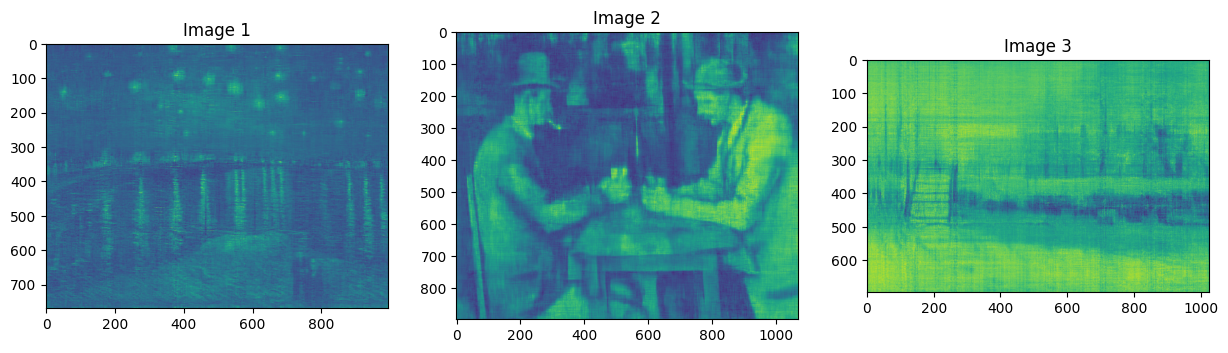

In [23]:
fig, axes = plt.subplots(1, len(reconstruction), figsize=(5*len(reconstruction),5))

for i in range(len(reconstruction)):

  axes[i].imshow(reconstruction[i]["W_5"] @ reconstruction[i]["Z_5"].T)
  axes[i].set_title(f"Image {i+1}")

plt.savefig("reconstruction_05_beta.png", dpi=300, bbox_inches='tight')
plt.show()

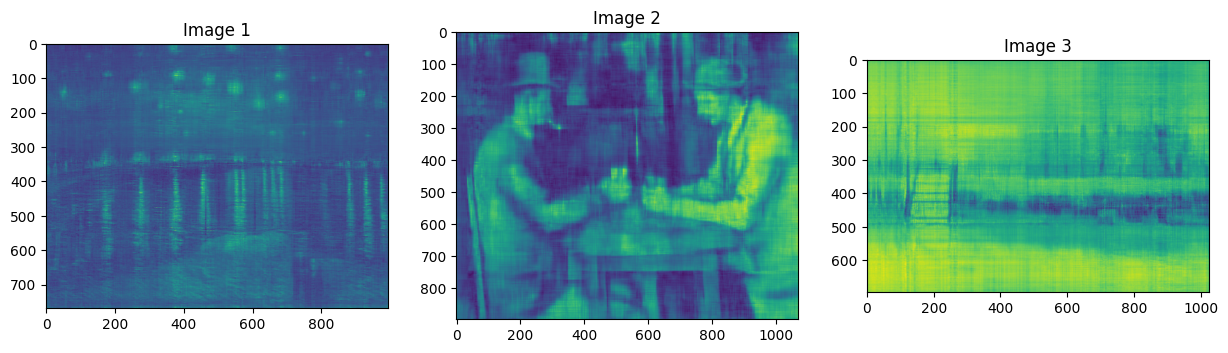

In [24]:
fig, axes = plt.subplots(1, len(reconstruction), figsize=(5*len(reconstruction),5))

for i in range(len(reconstruction)):

  axes[i].imshow(reconstruction[i]["W_1"] @ reconstruction[i]["Z_1"].T)
  axes[i].set_title(f"Image {i+1}")

plt.savefig("reconstruction_1_beta.png", dpi=300, bbox_inches='tight')
plt.show()